In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [3]:
FIL_BASE = 2_000_000_000.0
STORAGE_MINING = 0.55 * FIL_BASE
SIMPLE_ALLOC = 0.3 * STORAGE_MINING  # total simple minting allocation

In [4]:
days_np = np.arange(152, 1698+1)
days_jax = jnp.arange(152, 1698+1)

In [5]:
def ssse(x,y):
    return np.sqrt(np.sum((x-y)**2))

In [6]:
ssse(days_np, days_jax)

0.0

In [7]:
# NP
def np_cum_simple_minting(day: int, scale=True) -> float:
    LAMBDA = np.log(2) / (
        6.0 * 365
    )  # minting exponential reward decay rate (6yrs half-life)
    

    y = (1 - np.exp(-LAMBDA * day))
    if scale:
        y *= SIMPLE_ALLOC
    return y

In [8]:
def jax1_cum_simple_minting(day: int, scale=True) -> float:
    LAMBDA = jnp.log(2) / (
        6.0 * 365
    )  # minting exponential reward decay rate (6yrs half-life)
    y = (1 - jnp.exp(-LAMBDA * day))
    if scale:
        y *= SIMPLE_ALLOC
    return y
    
def jax2_cum_simple_minting(day: int, scale=True) -> float:
    LAMBDA = jnp.log(2) / (
        6.0 * 365
    )  # minting exponential reward decay rate (6yrs half-life)
    y = -1 * jnp.expm1(-LAMBDA*day)
    if scale:
        y *= SIMPLE_ALLOC
    return y

In [9]:
unscaled_np_res = np_cum_simple_minting(days_np, scale=False)
unscaled_jax1_res = jax1_cum_simple_minting(days_jax, scale=False)
unscaled_jax2_res = jax2_cum_simple_minting(days_jax, scale=False)

scaled_np_res = np_cum_simple_minting(days_np)
scaled_jax1_res = jax1_cum_simple_minting(days_jax)
scaled_jax2_res = jax2_cum_simple_minting(days_jax)

<IPython.core.display.Javascript object>


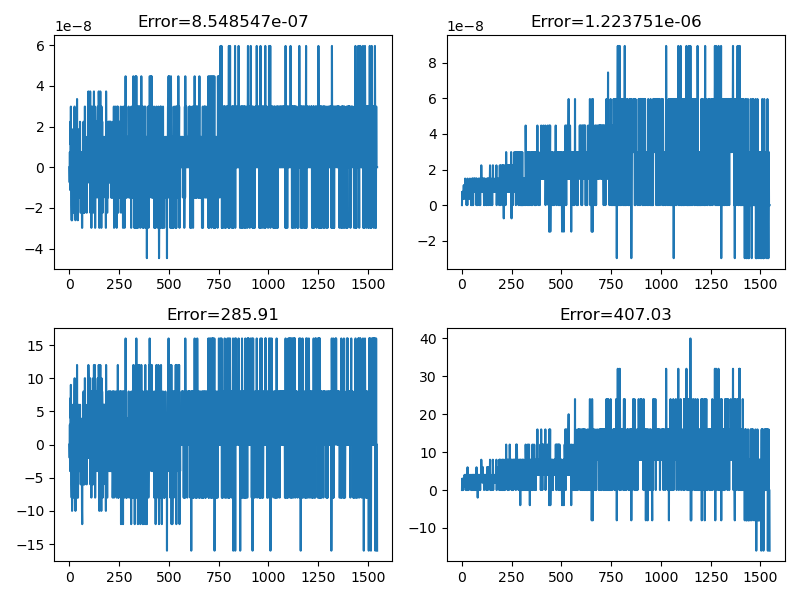

In [11]:
plt.figure(figsize=(8,6))

plt.subplot(2,2,1)
plt.plot(unscaled_np_res-unscaled_jax1_res)
plt.title('Error=%0.06e' % (ssse(unscaled_np_res, unscaled_jax1_res),))

plt.subplot(2,2,2)
plt.plot(unscaled_np_res-unscaled_jax2_res)
plt.title('Error=%0.06e' % (ssse(unscaled_np_res, unscaled_jax2_res),))

plt.subplot(2,2,3)
plt.plot(scaled_np_res-scaled_jax1_res)
plt.title('Error=%0.02f' % (ssse(scaled_np_res, scaled_jax1_res),))

plt.subplot(2,2,4)
plt.plot(scaled_np_res-scaled_jax2_res)
plt.title('Error=%0.02f' % (ssse(scaled_np_res, scaled_jax2_res),))

plt.tight_layout()